<h1 align="center"> IRIS data set </h1>

Download the IRIS data set from: <p></p>
 https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data <p></p>
 
 This is a data set of 150 points in R<sup>4</sup>, with three classes; refer to the website for more details of the features and classes. <p></p>
 
 <b>(a)</b> Use a PCA projection to 2d to visualize the entire data set. You should plot different classes using different colors/shapes. Do the classes seem well-separated from each other? <p></p>
 
 <b>(b)</b> Now build a classifier for this data set, based on a generative model. 


In [21]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

## Importing iris dataset

In [22]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data -O iris.txt

--2016-03-13 03:58:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [text/plain]
Saving to: `iris.txt'

100%[======================================>] 4,551       --.-K/s   in 0.002s  

2016-03-13 03:58:55 (2.71 MB/s) - `iris.txt' saved [4551/4551]



In [23]:
df = pd.read_csv('iris.txt', names=['sepal_len','sepal_wid','petal_len','petal wid','class'])
df.head()

,sepal_len,sepal_wid,petal_len,petal wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## (a) Perform PCA  to 2 components

In [24]:
pca = PCA(n_components = 2)
pca.fit(df.ix[:,0:4].values)
X = pca.transform(df.ix[:,0:4].values)

In [25]:
df['V0'] = X[:,0]
df['V1'] = X[:,1]
df.head()

,sepal_len,sepal_wid,petal_len,petal wid,class,V0,V1
0,5.1,3.5,1.4,0.2,Iris-setosa,-2.684207,-0.326607
1,4.9,3.0,1.4,0.2,Iris-setosa,-2.715391,0.169557
2,4.7,3.2,1.3,0.2,Iris-setosa,-2.889820,0.137346
3,4.6,3.1,1.5,0.2,Iris-setosa,-2.746437,0.311124
4,5.0,3.6,1.4,0.2,Iris-setosa,-2.728593,-0.333925


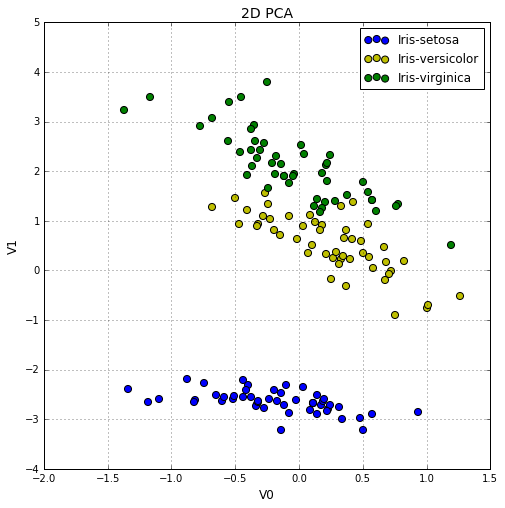

In [26]:
classes = df['class'].unique()
colors = ['b','y','g']
plt.figure(figsize = (8,8))
plt.xlabel('V0', fontsize = 12)
plt.ylabel('V1', fontsize = 12)
plt.title('2D PCA', fontsize = 14)
for cl, color in zip(classes,colors):
    V0 = df[df['class'] == cl]['V0'].values
    V1 = df[df['class'] == cl]['V1'].values
    plt.scatter(V1, V0, c = color, s = 50)
plt.legend(classes)
plt.grid()

The three classes appear to be well separated! 

iris-virginica and iris-versicolor could be better separated, but it is good!

## (b) Train with Multivariate Gaussian Classifier

In [27]:
#training dataset
df_train = df[df['class'] == classes[0]][0:35]
for c in classes[1::]:
    df_train = pd.concat([df_train, df[df['class'] == c][0:35]])

#test dataset
df_test = df[df['class'] == classes[0]][35::]
for c in classes[1::]:
    df_test = pd.concat([df_test, df[df['class'] == c][35::]])

For our classifier, we will use a Multivariate Gaussian.

$$X \sim N_{4}(\mu,\Sigma) $$

As all the classes are of the same size, we will not incorporate $\pi$ into the equation.

$$\pi_{setosa}=\pi_{vesicolor}=\pi_{virginica}$$

We will be using the log of our probability density function to avoid overlfow or underflow.

In [35]:
def classify(sample_df, valid_df):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in xrange(3): 
        cond = sample_df['class'] == classes[label]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values))
        func = multivariate_normal(mean=mean, cov=cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    tf_error = [classes[i] != j for i,j in zip(max_prob, valid_df['class'])]
    #Compare with valid target to get error
    error = np.sum(tf_error)/len(valid_df)
    return error

## Train the dataset

In [29]:
def find_error(sample_df, valid_df):

    #Empty list for probabilities
    prob = []

    #Find probability of each classifier
    for label in xrange(3): 
        cond = sample_df['class'] == classes[label]
        mean = np.mean(sample_df[cond].ix[:,0:4].values, axis = 0)
        cov = np.cov(np.transpose(sample_df[cond].ix[:,0:4].values))
        func = multivariate_normal(mean, cov)
        prob.append(func.logpdf(valid_df.ix[:,0:4]))

    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    #Compare with valid target to get error
    label = []
    flower = []
    probability = []
    prob = np.matrix(prob)
    for i,j,k in zip(max_prob, valid_df['class'], range(len(valid_df))):
        if  classes[i] != j:
            flower.append(j)
            label.append(classes[i])
            probability.append(prob[:,k])
    return [flower, label, probability]

In [30]:
#Get values
[flower, label, probability] = find_error(df_train, df_train)

In [34]:
#Create dataframe of flowers and predictions
error_df1 = pd.DataFrame({'prediction': label, 'flower':flower})
error_df1.head()

,flower,prediction
0,Iris-versicolor,Iris-virginica
1,Iris-virginica,Iris-versicolor


We can see that the 2 errors in our train dataset were caused by Iris-versicolor and Iris-virginica. This is expected as we have seen overlaps between these 2 classed on our 2D scatter plot. 

Let's look at the probabilities of the first 2 predictions.

In [32]:
#Analyze the probabilities of each specie occuring
error_df2 = pd.DataFrame(probability[0])
error_df2[1] = probability[1]
error_df2.columns = xrange(2)
error_df2.index=classes
error_df2

,0,1
Iris-setosa,-261.676750,-249.210061
Iris-versicolor,-1.766901,-0.919125
Iris-virginica,-0.441845,-1.020240


We can see that iris-versicolor and iris-virginica are really close in probability. Iris-setosa has an extremely low probability of occuring, as can verified using the 2D scatter plot.

#### Test Dataset

For our final test, we will not use smooth or PCA.

$$X \sim N_{4}(\mu,\Sigma)$$

In [33]:
error = classify(df_train, df_test)

print('Error:\t',error)

('Error:\t', 0)


We have achieved a 100% accuracy on our test dataset.